In [322]:
import numpy as np
import pandas as pd # at least 0.23
import sklearn
import scipy.sparse as sparse
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import groupby
from lightfm import data, LightFM, evaluation, cross_validation
from random import shuffle
from skopt import forest_minimize
from operator import itemgetter

## Data Overview

### Dataset Structures

Let's first take a look at the provided datasets.

In [323]:
books = pd.read_csv("../../data/Books.csv", encoding="ISO-8859-1", index_col=0).reset_index(drop=True)
users = pd.read_csv("../../data/Users.csv", encoding="ISO-8859-1", index_col=0).reset_index(drop=True)
events = pd.read_csv("../../data/UserEvents.csv", encoding="ISO-8859-1", index_col=0).reset_index(drop=True)

display(books.head())
display(users.head())
display(events.head())

bookISBN                                           bookName  \
0  0773730982                       Stretch, Swallow &amp; Stare   
1  0916620867    The Two Faces of Religion: A Psychiatrists View   
2  0380978598                                        Roma Eterna   
3  0802727719  For Everything a Season: Simple Musings on Liv...   
4  0446604178  Mountain, Get Out of My Way: Life Lessons and ...   

                       author yearOfPublication           publisher     urlId  
0  Veronika Martenova Charles              1999       Stoddart Kids    8040.0  
1                 N.S. Xavier              1987          Portals Pr   46584.0  
2           Robert Silverberg              2003                 Eos   39681.0  
3               Philip Gulley              2001  Walker Large Print   29478.0  
4             Montel Williams              1997   Warner Books (Mm)  104573.0

user                        location   age
0  177122.0       winter park, florida, usa  50.0
1  174022.0        fairview park, ohio, usa   NaN
2  179442.0  farmville, north carolina, usa  45.0
3   44392.0            weston, florida, usa  65.0
4   89251.0       duesseldorf, n/a, germany   NaN

user      bookId   impression
0  126736  0843946806      dislike
1  208406  0345353145         like
2    8890  2020213508  add to cart
3   78553  0451402383  add to cart
4   27875  0307129659  add to cart

### High Level Issues

As stated in the assignment, we want to predict what book a user will buy next. Given the data, this is a difficult problem, due to the following reasons:

#### Response Variable is multi-dimensional

We are dealing with two types of feedback - explicit (`like` and `dislike`) and implicit(`interact`, `view`, `add to cart` and `checkout`).

The two different types of feedback are usually perceived in different ways when building a recommender system.

With explicit feedback, feedback can be positive or negative. A low rated movie means the user doesn't like that kind of movie.

Implicit feedback is based on the belief that a user who interacts in any way with an item, shows some degree of interest (with different levels of confidence) in the item simply be interacting with it. **Any feedback is positive feedback.** The lack of interaction with an item is an indication of a user not being interested in the item, and is thus considered as negative feedback. More information about implicit feedback can be found [here](http://yifanhu.net/PUB/cf.pdf).

Given the data, it makes more sense to consider the feedback as implicit, since most of the impressions are implicit in nature.

#### No Timestamps

The user events don't have any timestamps. This poses a problem, because we do not know the sequence of events per user. We do not know whether a user's book interests changed over time. Since the timestamps aren't available, the only thing to do, is to make the assumption that each user's book interests stay constant across time.

This means that instead of trying to predict the next book a user will buy, we have to predict whether a person will buy **a** book, regardless of the user's historical data timeline.

### Event Statistics

In [324]:
# some high level stats
n_books = books.bookISBN.nunique()
n_users = users.user.nunique()

events_summary = pd.DataFrame(events.impression.value_counts())
events_summary['mean_per_user'] = events_summary.impression/len(users)
events_summary['mean_per_book'] = events_summary.impression/len(books)

events_summary.rename(columns={'impression': 'count'}, inplace=True)

print("Number of unique books for sale: {}".format(n_books))
print("Number of users: {}\n".format(n_users))
display(events_summary)

Number of unique books for sale: 150000
Number of users: 97993



count  mean_per_user  mean_per_book
interact     104525        1.04525       0.696833
like          95838        0.95838       0.638920
checkout      72443        0.72443       0.482953
add to cart   62282        0.62282       0.415213
view          55212        0.55212       0.368080
dislike        9700        0.09700       0.064667

From the impression statistics above, we get an idea of how prominent each of the impressions are. `dislike` occurs way less than any of the other recorded impressions. Since we are considering these impressions as implicit feedback, we have the choice to either consider a `dislike` as no interaction, or as positive feedback with a very low level of confidence. However, the proportionally small number of dislikes means that this choice most likely won't have a significant effect on our model. For now we'll make the assumption that a "dislike" shows some level of interest in the type of item, even though it might be very low.

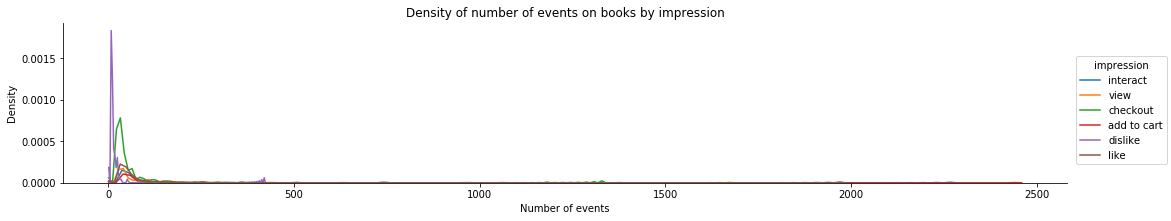

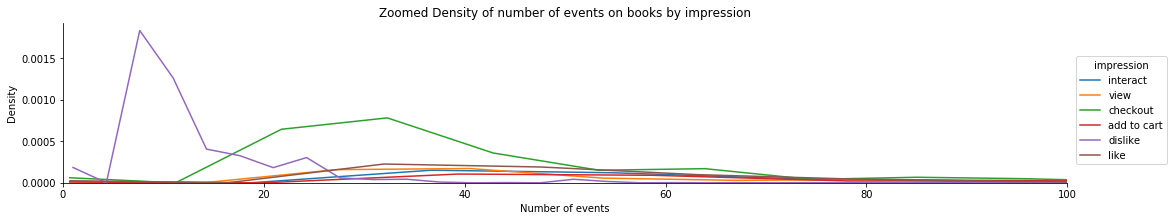

In [325]:
user_checkouts = events.groupby(['user', 'impression']).count().reset_index()

g = sns.FacetGrid(user_checkouts, hue="impression", aspect=5, legend_out=True)
g.map(sns.distplot, "bookId", hist=False, rug=False)
g.add_legend()
g.set(xlabel='Number of events', ylabel='Density', title = 'Density of number of events on books by impression')
plt.show()

g = sns.FacetGrid(user_checkouts, hue="impression", aspect=5, legend_out=True)
g.map(sns.distplot, "bookId", hist=False, rug=False)
g.add_legend()
g.set(xlabel='Number of events', ylabel='Density', title = 'Zoomed Density of number of events on books by impression', xlim=(0, 100))
plt.show()

In [326]:
user_checkouts_summary = user_checkouts.groupby('impression').bookId.describe(percentiles = [0.05, 0.25, 0.5, 0.75, 0.95])
user_checkouts_summary.rename(columns={'count': 'Unique User Count'}, inplace=True)
display(user_checkouts_summary)

print("Users with more than 2 impressions by impression type\n")
user_checkouts_summary_2 = user_checkouts[user_checkouts.bookId > 2].groupby('impression').bookId.describe(percentiles = [0.05, 0.25, 0.5, 0.75, 0.95])
user_checkouts_summary_2.rename(columns={'count': 'Unique User Count'}, inplace=True)
display(user_checkouts_summary_2)

Unique User Count      mean        std  min   5%  25%  50%  75%  \
impression                                                                     
add to cart            20414.0  3.050945  20.526119  1.0  1.0  1.0  1.0  2.0   
checkout               19425.0  3.729369  18.656569  1.0  1.0  1.0  1.0  2.0   
dislike                 5896.0  1.645183   5.807890  1.0  1.0  1.0  1.0  1.0   
interact               33746.0  3.097404  15.174995  1.0  1.0  1.0  1.0  2.0   
like                   31635.0  3.029493  15.930427  1.0  1.0  1.0  1.0  2.0   
view                   19695.0  2.803351  17.167464  1.0  1.0  1.0  1.0  2.0   

              95%     max  
impression                 
add to cart   9.0  2459.0  
checkout     12.0  1339.0  
dislike       4.0   423.0  
interact     10.0  2284.0  
like         10.0  1985.0  
view          8.0  1686.0

Users with more than 2 impressions by impression type



Unique User Count       mean        std  min   5%  25%  50%  \
impression                                                                 
add to cart             4380.0   9.932420  43.625621  3.0  3.0  3.0  5.0   
checkout                4399.0  12.476472  37.918942  3.0  3.0  3.0  5.0   
dislike                  641.0   5.781591  17.043484  3.0  3.0  3.0  4.0   
interact                7816.0   9.428608  30.686548  3.0  3.0  3.0  5.0   
like                    6614.0  10.054430  33.926871  3.0  3.0  3.0  5.0   
view                    4044.0   9.052423  37.227463  3.0  3.0  3.0  4.0   

              75%   95%     max  
impression                       
add to cart   9.0  27.0  2459.0  
checkout     11.0  37.0  1339.0  
dislike       5.0  11.0   423.0  
interact      9.0  27.0  2284.0  
like          9.0  30.0  1985.0  
view          7.0  22.0  1686.0

The density plots and summary tables reveal that many users have very few impressions (if we filter out the users with 1 impression by impression type, it reduces the number of samples significantly).

This motivates the inclusion of all possible datasets, such as user and item metadata. This will result in an increased time and memory complexity for both model training and predicting, but if it significantly increases the accuracy score while being realistically fast enough, it's worth considering.

### Event Characteristics

In [327]:
events[['user', 'bookId']].duplicated().value_counts()

False    400000
dtype: int64

The above output is an indication that each user-item item is unique. This means that a user cannot have more than 1 impression on any given book. 

For this reason the assumption is made that the captured `impression` is the **most positive** captured impression the given user-item interaction. For example, if a user viewed and bought a book, the user-item impression will be `checkout` opposed to `view`.

### Response Variable - Impression

As noted earlier, we will handle the feedback as implicit feedback. This means that we need to associate a level of confidence with each impression class, where a maximum confidence score represents a user buying an item.

Because we are considering the impressions as implicit feedback, we should consider `dislike` as a positive impression with a very low level of confidence that the user wants to buy that item. `checkout` indicates a high confidence level.

We are making the assumption that the impressions can be ranked in the following order (from lowest to highest probability in terms of whether the user will buy a given book):

- dislike
- view
- interact
- like
- add to cart
- checkout

## Choosing an appropriate recommender system package

There are many Python packages that can be used for building a recommender system.

Two packages that stand out in terms of handling implicit feedback, while remaining scalable (opposed to something like a deep neural network), are:

* [implicit](https://github.com/benfred/implicit)
* [lightFM](https://lyst.github.io/lightfm/docs/index.html#)

Both of these can assist in creating hybrid models, but have their own pros and cons.

### Implicit Package

This package only makes use of user-item interaction data. It's used at companies, such as Flipboard (I feel like Bonsai will find this [paper](https://www.ntnu.no/wiki/download/attachments/71733389/WEBIST%202013%20Gulla%20Final.pdf?version=1&modificationDate=1400066459000&api=v2) very useful), because in a lot of cases implicit feedback is all that's needed to make good recommendations. The package also allows GPU acceleration, if available. This means that training and recommending can take place much faster.

### LightFM Package

As with the implicit package, LightFM focuses uses implicit feedback. It has the added benefit over `implicit` of including user and item features, such as metadata. This results in longer training and prediction times, but since it still relies on matrix computations, most of processing can be split across CPU cores, which means it can still be implemented in a practical fashion.

Since the provided datasets are *relatively* small, and the number of interactions are limited (which means user and item metadata will come in handy), LightFM is the package of choice for this problem.

## Create Response Variable

Since we cannot process the `impression` classes as-is, we need to quantify impression as confidence levels of how strongly we believe the user will buy the book, given a confidence score. Opposed to dealing with explicit feedback, we aren't interested in predicting the rating of a user-item pair. As long as the distance between the impressions are fairly realistic, it's okay. Implicit data is noisey by nature.

In [328]:
checkout_probability = {'dislike': 10**-5, 
                      'view': 0.5, 
                      'interact': 0.7, 
                      'like': 0.8, 
                      'add to cart': 0.9, 
                      'checkout': 1.0}

events['checkout_probability'] = [checkout_probability[x] for x in events.impression]

## Data Cleaning

### User Features

#### Location

The user locations provided aren't usable as-is.

We need to clean and parse it and extract locations that are high-level enough so that we might have some users who share locations (and possibly book interests).

In [329]:
# assume location has letters only and hierarchy is split by comma
user_locations = users.location.str.replace(r'[^a-zA-Z\,]+', '', regex=True)

# assume levels are comma seperated
user_locations = user_locations.str.split(',', expand=False)

# loop though iterable user locations
for i, i_loc in enumerate(user_locations):
    # remove any duplicate neighbouring geolevel entries
    # (e.g. Durbanville, South Africa, South Africa -> Durbanville, South Africa)
    # 
    # check if there is an available location and 
    # whether there are any duplicate entries in the list
    if isinstance(i_loc, list) and len(set(i_loc)) < len(i_loc):
        # remove duplicates
        user_locations[i] = [x for x, _ in groupby(i_loc)]
    # if empty string (we replaced non-alphabetical values with '')
    # or empty
    # replace with placeholder list to maintain iterable data type
    elif not isinstance(i_loc, list):
        user_locations[i] = []
    else:
        pass

# create dataframe for locations (messy seperated columns)
user_locations = pd.DataFrame(user_locations.tolist())

# get 2 highest geolevels per user
def two_lasts(row):
    """
    Get two highest geolevels per user
    """
    # get index of highest geolevel entry
    last_loc_entry = row.last_valid_index()
    
    # if there is something, return return the last two column values
    if last_loc_entry is not None:
        return row.iloc[list(range(last_loc_entry-1, last_loc_entry+1))].reset_index(drop=True)
    else:
        return None

# get two highest geo-levels
user_locations = user_locations.apply(two_lasts, axis=1)
# rename columns
user_locations.columns = ['region', 'country']

# join with other user metadata
users = users[['user', 'age']].join(user_locations)

In [330]:
users.head()

user   age         region  country
0  177122.0  50.0        florida      usa
1  174022.0   NaN           ohio      usa
2  179442.0  45.0  northcarolina      usa
3   44392.0  65.0        florida      usa
4   89251.0   NaN             na  germany

Next we need to take care of misspelt or incorrectly specified region and country names.

If there is only a single user for a given country, it might be due to the user misspelling or incorrectly specifying it.

Below we'll be attempting to find these users more likely locations, based on the number of users in different recorded locations.

In [331]:
# count number of users per country
counts = users.groupby(['country']).size()
# identify users of unique countries
# more than one user per location, 
# is assumed to be from a real location
counts = counts[counts <= 1].reset_index()
# replace these countries with 'missing' placeholder values
# np.nan is more preferable as a placeholder, but doesn't 
# work well with some of the preprocessing taking place
# further down
users.loc[users.country.isin(counts.country) , 'country'] = 'missing'

In [332]:
users.loc[users.country == 'missing', :].head()

user   age             region  country
778   228450.0  28.0  guangdongprovince  missing
1038  169842.0  29.0             italia  missing
1055  203284.0   NaN   caramelappleland  missing
2030   32425.0   NaN                 fl  missing
2497   46143.0   NaN                 bc  missing

As commented in the code above, `np.nan` is a better placeholder value than `"missing"`, but it doesn't react in the desired way with the preprocessing shown below. For this reason, we are also replacing actual missing region values, with `"missing"` placeholder values.

Our regex activities above also resulted in a few empty locations that needs to be replaced.

In [333]:
# replace missing locations
users.loc[pd.isna(users.region), 'region'] = 'missing'
users.loc[pd.isna(users.country), 'country'] = 'missing'

# declare obvious missing string values that need replacing
miss_string = ['', 'na']

# replace with general missing label
users.loc[users.region.isin(miss_string), 'region'] = 'missing'
users.loc[users.country.isin(miss_string), 'country'] = 'missing'

In [334]:
users.loc[users.country == 'missing', :].head()

user   age              region  country
20  130221.0  49.0             missing  missing
30   86497.0  24.0  nordrheinwestfalen  missing
50  214908.0  30.0             quarona  missing
71   79200.0   NaN             missing  missing
91  236193.0  38.0             missing  missing

For each unique region(by country), we can check to see if that region occurs more frequently in a different country (based on other users). The country with the most users for the specific region name, is most likely to be the correct country name (opposed to the one provided by the user).

If the unique region doesn't exist in a different country, it might be the case that the user's country is correct, but the region is incorrectly specified (or very unpopular in the users country). We can change the user's region to the most common city in the user's country (As a user feature value this "common city" name replacement will actually not add any value in addition to the user's country name). But again, for preprocessing purpopses, it makes sense to do this for now.

If both the region and the country are unfamiliar, we need to replace it with our default general `missing` values.

In [335]:
# count unique regions by country
counts = users.groupby(['country', 'region']).size()
# identify users from unique regions
fake = counts[counts <= 1].reset_index()
# identify users  from non-unique regions
legit = counts[counts > 1].reset_index()
# rename columns
fake.rename(columns={0: 'count'}, inplace=True)
legit.rename(columns={0: 'count'}, inplace=True)

In [336]:
print("\nUnique regions\n")
display(fake.head())
print("\nNon-unique regions\n")
display(legit.head())


Unique regions



country       region  count
0  afghanistan      alabama      1
1  afghanistan   california      1
2  afghanistan  connecticut      1
3  afghanistan      georgia      1
4  afghanistan     kandahar      1


Non-unique regions



country       region  count
0  afghanistan      ontario      2
1      albania      missing      3
2      algeria       bejaia      2
3      algeria  constantine      2
4      andorra    catalunya      2

In [337]:
# make copy to map with new locations later
fake_original = fake.copy()

# get unique region names (by country)
fake_country_regions = fake.region.unique()
    
# find better region, country combinations
for fcr in fake_country_regions:
    # find other countries with the same region name
    # the legit dataframe contains locations with at least 
    # 2 users
    fc_real = legit.loc[legit.region == fcr, :]
    
    if not fc_real.empty:
        # if there are other countries with the region name
        # we change the user's country name to the more 
        # likely country name
        fc_real = fc_real.loc[fc_real['count'].idxmax(), 'country']
        fake.loc[fake.region == fcr, 'country'] = fc_real
    else:
        # if no other country is a likely alternative
        # we change the region name to the most popular 
        # region name within the users country
        fcr_country = fake.loc[fake.region == fcr, 'country']
        fc_real = legit.loc[legit.country == fcr_country.to_string(index=False), :]
        if not fc_real.empty:
            fr_real = fc_real.loc[fc_real['count'].idxmax(), 'region']
            fake.loc[fake.region == fcr, 'region'] = fr_real
        else:
            # if the user is the only recorded user in his country, with no 
            # location alternatives, we assign a general location
            fake.loc[fake.region == fcr, ['region', 'country']] = 'missing'

# join users with new locations
fake_original = fake_original.join(fake, rsuffix="_better")
# drop counts
fake_original.drop(columns=['count', 'count_better'], inplace=True)

fake_original.head(20)

country               region country_better        region_better
0   afghanistan              alabama            usa              alabama
1   afghanistan           california            usa           california
2   afghanistan          connecticut            usa          connecticut
3   afghanistan              georgia            usa              georgia
4   afghanistan             kandahar         canada              ontario
5   afghanistan              missing        missing              missing
6       albania                  abc        albania              missing
7       albania              alabama            usa              alabama
8       albania           basilicata          italy           basilicata
9       albania  friuliveneziagiulia          italy  friuliveneziagiulia
10      albania               kosovo        missing              missing
11      albania            lombardia          italy            lombardia
12      albania             sardegna          italy             sardegna
13      albania                texas            usa                texas
14      albania       yukonterritory         canada       yukonterritory
15     alderney              alberta         canada              alberta
16     alderney               bremen        germany               bremen
17     alderney           washington            usa           washington
18      algeria       algiersalgeria        algeria               bejaia
19      algeria               bouira        algeria               bejaia

It has a few flaws, but it will have to do for now.

In [338]:
# merge users with unique regions with original user location dataframe
users = users.merge(fake_original, how='left', on=['country', 'region'])

# replace the unique locations with more sensible locations
users[['country_better', 'region_better']] = np.where(users[['country_better', 'region_better']].isnull(), 
                                                              users[['country', 'region']], 
                                                              users[['country_better', 'region_better']])

users.head()

user   age         region  country country_better  region_better
0  177122.0  50.0        florida      usa            usa        florida
1  174022.0   NaN           ohio      usa            usa           ohio
2  179442.0  45.0  northcarolina      usa            usa  northcarolina
3   44392.0  65.0        florida      usa            usa        florida
4   89251.0   NaN        missing  germany        germany        missing

In [339]:
# replace and remove redundant columns
users.drop(columns=['region', 'country'], inplace=True)
users.rename(columns={'country_better': 'country', 'region_better': 'region'}, inplace=True)
users.head()

user   age  country         region
0  177122.0  50.0      usa        florida
1  174022.0   NaN      usa           ohio
2  179442.0  45.0      usa  northcarolina
3   44392.0  65.0      usa        florida
4   89251.0   NaN  germany        missing

#### Age

Age is a user feature that we might want to consider. Since it's a continuous, numeric variable it doesn't increase the dimensionality much (which is a good thing).

In [340]:
users.age.describe()

count    59050.000000
mean        34.785656
std         14.377491
min          0.000000
25%         24.000000
50%         32.000000
75%         44.000000
max        230.000000
Name: age, dtype: float64

There are unreasonably aged people whose age we need to change (otherwise these outliers will mess with the `age` feature). Any underaged person or a person older than 80 will get their age changed.

We also need to replace missing age values.

The best we can do is to replace these values with the **median** age value. This will serve the same purpose as our **general** `missing` location class - a neutral value with little influence.

**Note:** In practice we can omit the incorrect data, instead of replacing it. It's just because this method is a bit faster that this is done in the meantime.

In [341]:
users.loc[(users.age < 18.0) | (users.age > 80.0) | pd.isna(users.age), 'age'] = users.age.median()

#### User IDs

We need to make sure that all users with metadata actually have user IDs. If not, we won't be able to map them to events, which means they are useless.

In [342]:
# check for missing values
print("{} missing user IDS with metadata".format(users.user.isnull().sum()))

2007 missing user IDS with metadata


The only thing we can do, is to remove these users, since we don't know who they are.

In [343]:
print("Number of users before removal: {}".format(users.shape[0]))
# remove mysterious users
users = users.loc[~users.user.isnull(), :]
print("Number of users after removal: {}".format(users.shape[0]))

Number of users before removal: 100000
Number of users after removal: 97993


We should also change the formatting of the IDs.

In [344]:
# change userID format to a more sensible string format
users['user'] = users['user'].astype('int32').astype('str')
events['user'] = events['user'].astype('int32').astype('str')

### Item Features

#### Book IDs

Firstly, let's change the formats.

In [345]:
# change userID format to a more sensible string format
books['bookISBN'] = books['bookISBN'].astype('str')
events['bookId'] = events['bookId'].astype('str')

In [346]:
books.head()

bookISBN                                           bookName  \
0  0773730982                       Stretch, Swallow &amp; Stare   
1  0916620867    The Two Faces of Religion: A Psychiatrists View   
2  0380978598                                        Roma Eterna   
3  0802727719  For Everything a Season: Simple Musings on Liv...   
4  0446604178  Mountain, Get Out of My Way: Life Lessons and ...   

                       author yearOfPublication           publisher     urlId  
0  Veronika Martenova Charles              1999       Stoddart Kids    8040.0  
1                 N.S. Xavier              1987          Portals Pr   46584.0  
2           Robert Silverberg              2003                 Eos   39681.0  
3               Philip Gulley              2001  Walker Large Print   29478.0  
4             Montel Williams              1997   Warner Books (Mm)  104573.0

The useful item features are (share among items):

* author
* year of Publication (debatable)
* publisher

Due to limited time, let's only check that the years are clean and make sense. The other feature columns will have to be used as-is (this is not ideal).

In [347]:
# select columns to be used
# item_features = books.loc[:, ['author', 'yearOfPublication', 'publisher']]

# identify and remove non-numeric
books['yearOfPublication'].replace(r'[^0-9]+', 'missing', regex=True, inplace=True)
books = books.loc[books.yearOfPublication != 'missing', :]

# change format
books['yearOfPublication'] = books['yearOfPublication'].astype('int32')

In [348]:
books.yearOfPublication.describe()

count    149998.000000
mean       1960.385045
std         255.667170
min           0.000000
25%        1989.000000
50%        1995.000000
75%        2000.000000
max        2050.000000
Name: yearOfPublication, dtype: float64

Let's remove future years and years smaller than the 5% quantile year value. (Below we're replacing it with the median - this is unnecessary, but easiest given the assessment time constraint).

In [349]:
lower_q = books.yearOfPublication.quantile(0.05)
year_median = books.yearOfPublication.median()
books['yearOfPublication'] = np.where((books.yearOfPublication < lower_q) | (books.yearOfPublication > 2018), year_median, books.yearOfPublication)

In [350]:
books.yearOfPublication.describe()

count    149998.000000
mean       1994.467246
std           6.630874
min        1976.000000
25%        1990.000000
50%        1995.000000
75%        2000.000000
max        2012.000000
Name: yearOfPublication, dtype: float64

That's better.

## Define Feature Space

We need to define all our known users, books and user features to be used in our model.

If a new user, book or user meta data wants to be added to our feature space, we need to apply a partial fit. No need to start from scratch.

### Define Users

First we need to inform our model about all our users we want to make recommendations for.

The assumption is that we don't only want to predict for users who have interacted with products, but all users we have information for - this includes users with metadata, but who have never interacted with products, as well as users who have interacted with products, but who we don't have any metadata for.

In [351]:
# the only people we are omitting are the people with unusable
# metadata and who have never interacted with any product
users_unique = pd.Series(events.user.unique()).append(users.user).unique()
print("Number of unique users: {}".format(len(users_unique)))

Number of unique users: 145933


### Define Items

Next we need to inform our model of all the items it can possibly recommend to our users.

In [352]:
items_unique = pd.Series(books.bookISBN).append(pd.Series(events.bookId.unique())).unique()
print("Number of unique books: {}".format(len(items_unique)))

Number of unique books: 247429


So we are dealing with another odd situation - there are books that users have bought, that aren't in our books table.

The assumption is that we have books that we are selling, but we don't have any metadata for. These should still be allowed as recommendations (other users interacting with these books can be sufficient to recommend it).

### Define User Features

Since our user metadata may help with useful recommendations, we want to provide this to our model.

In [353]:
# define user feature names
# 
# for country we are essentially doing the same 
# as one-hot encoding (each country becomes its own feature)
# 
# we don't want to do this in our dataframe since this will 
# result in a large number of zeros that serve no purpose
# 
# instead we try to get the user features directly into a 
# sparse matrix
user_feature_names = list(users.country.unique())
user_feature_names.append('age')

# create user feature iterable across users
cols = ['age', 'country']
user_features = users.apply(lambda x: (x['user'], dict(zip([cols[0], x[cols[1]]], [x[cols[0]], 1.0]))), axis=1)

In [354]:
# example
user_features[0]

('177122', {'age': 50.0, 'usa': 1.0})

### Define Item Features

If we have somewhat sensible metadata for an item, we need to provide it to the model, with the hope of providing better recommendations.

In [355]:
# define item feature names
# 
# for author and publisher we are essentially doing the same 
# as one-hot encoding (each author and publisher becomes its own feature)
# 
# we don't want to do this in our dataframe since this will 
# result in a large number of zeros that serve no purpose
# 
# instead we try to get the item features directly into a 
# sparse matrix
item_feature_names = list(books.author.unique())
item_feature_names.extend(list(books.publisher.unique()))
item_feature_names.append('yearOfPublication')

# create user feature iterable across users
cols = ['author', 'publisher', 'yearOfPublication']
item_features = books.apply(lambda x: (x['bookISBN'], dict(zip([x[cols[0]], x[cols[1]], cols[2]], 
                                                                        [1.0, 1.0, x[cols[2]]]))), axis=1)

In [356]:
# example
item_features[0]

('0773730982',
 {'Veronika Martenova Charles': 1.0,
  'Stoddart Kids': 1.0,
  'yearOfPublication': 1999.0})

### Defining the Feature Space

Now we can define the feature space. This will assist in mapping events and user and item metadata to our defined features.

In [357]:
print("Number of users: {}".format(len(users_unique)))
print("Number of items: {}".format(len(items_unique)))
print("Number of user features: {}".format(len(user_feature_names)))
print("Number of item features: {}".format(len(item_feature_names)))

Number of users: 145933
Number of items: 247429
Number of user features: 146
Number of item features: 78727


In [360]:
feature_space = data.Dataset()
feature_space.fit(users=users_unique, items=items_unique, user_features=user_feature_names, item_features=item_feature_names)

## Create Train and Validation Datasets

We need to hold out a number of historical interactions as validation data to use as a more trustworthy score, opposed to training accuracy.

In [39]:
interactions = events[['user', 'bookId', 'checkout_probability']]
interactions = list(interactions.itertuples(index=False, name=None))
# convert to sparse matrix
interactions = feature_space.build_interactions(data=interactions)

# train test split
# 
# random state argument has a bug :/
# future improvement - write own split function
interactions_train, interactions_test = cross_validation.random_train_test_split(interactions[0], test_percentage=0.2)

## Create Sparse Matrices for Metadata

We still need to map our metadata to our users and items and get it into sparse matrix form.

In [362]:
# build feature sparse matrices
user_features = feature_space.build_user_features(data=user_features)
item_features = feature_space.build_item_features(data=item_features)

## Model Fitting and Evaluation

Now that our feature space is defined and our data has been split, we can fit and evaluate our model.

**Note:** Many of the steps that follow have been done in ways to save on time. For example, with parameter tuning, a very limited space was explored. If this model were to be implemented in a production environment, a more diligent process should be followed to ensure appropriate paramter values resulting in the best possible cross validation scores (cross validation isn't applied below, for the same time-related reasons).

As discussed at the start of the notebook we have selected to make use of the LightFM package. It allows us to run model fitting and prediction on multiple CPUs in parallel, since most of our calculations involve matrices.

The model below is a hybrid model that makes use of user-item interactions, as well as user and item metadata.

### Parameter Tuning

There are a number of parameters we can optimise for. Below we apply a few unrealistically strict limits to the search space to save time.

#### Number of Components

We are applying an upper limit of 10 to the number of components. This means that our model might (most likely) underfit. This upper limit is simply applied to limit training time.

#### Loss Function

Two loss functions are considered:

* WARP (Weighted Approxiamate-Ranked Pairwise) - [WARP recommender system paper](http://www.ee.columbia.edu/~ronw/pubs/recsys2013-kaos.pdf)
* BPR (Bayesian Personalised Ranking) - [BPR Implicit paper](https://arxiv.org/pdf/1205.2618.pdf)

THe two loss functions work in slightly different ways.

WARP regards the accuracy of higher ranked recommendations as more important (weighted) than recommendations further down the line.

BPR tries to maximise the distance between positive and negative feedback. Remember, positive feedback is any feedback. Negative feedback is the lack of feedback. This is useful when you're interested in both true positives and true negatives. Because we are trying to maximise ROC AUC (as per assessment), it is expected that BPR will outperform WARP. However, there are many examples where WARP outperforms BPR on ROC AUC - hence why both loss functions are considered.

#### Epochs

The number of epochs is constrained to an upper limit of 10. Given the complexity of our model and our large future space, this upper limit is most likely too low. Again this is simply done to save on trainnig time.

#### Learning Rate

This value is the initial learning rate used during gradient descent (adagrad learning schedule by default). The learning rate decreases as the number of iterations increases to prevent unexpected behaviour during optimisation.

#### User and Item Alpha Values

The L2 regularization penalty applied to user and item features.

## Model Evaluation

### Parameter Tuning

There are quite a few hyperparameters we can optimise to maximize the ROC AUC score.

Below we search the parameter space and trying to maximize our ROC AUC score on our validation data. We do this by specifying ROC AUC as a loss function (simply -1*ROC_AUC) and trying to minimize this loss function. We are using the `forest_minimize` function from the `scikit-optimise` back, which is based on a decision tree approach to find the best parameters. This is a useful way of parameter tuning when the relationship between the different parameters is complex.

In [42]:
def rec_sys_objective(params):
    """
    Recommender system objective function. To accommodate the parameter 
    search function, we need to ensure that we want to minimize the 
    objective function. In this case we try to minimize the negative 
    ROC AUC score on our validation data.
    """
    
    # define input parameters
    epochs, lr, no_components, user_alpha, item_alpha, loss = params
    
    # specify model parameters
    model = LightFM(loss=loss, 
                   random_state=1234, 
                   learning_rate=lr, 
                   no_components=no_components, 
                   user_alpha=user_alpha, 
                   item_alpha=item_alpha)
    
    # fit model with specific number of epochs
    model.fit(interactions=interactions_train, 
              user_features= user_features, 
              item_features=item_features, 
              epochs=epochs, 
              num_threads=6)
    
    # calculate ROC AUC score per user
    auc_score = evaluation.auc_score(model, 
                                     test_interactions=interactions_test, 
                                     train_interactions=interactions_train, 
                                     user_features = user_features, 
                                     item_features = item_features, 
                                     num_threads=6)
    
    # get mean ROC AUC value across users
    auc_score_mean = auc_score.mean()
    
    # negative to ensure correct minimizing
    min_score = -auc_score_mean
    
    return min_score

In [43]:
# define search space
# note: it's a very limited space to 
# minimize runtime
parameter_space = [
    (1, 10), # epochs
    (10**-4, 1.0, 'log-uniform'), # learning rate 
    (2, 20), # number of components
    (10**-6, 10**-3, 'log-uniform'), # user regularization alpha value 
    (10**-6, 10**-3, 'log-uniform'), # item regularization alpha value
    ['bpr', 'warp'] # loss function
]

# search for best paramters
rec_sys_opt = forest_minimize(rec_sys_objective, 
                             parameter_space, 
                             n_calls=100, 
                             random_state=1234, 
                             verbose=True, 
                             n_jobs=6)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 181.3878
Function value obtained: -0.6336
Current minimum: -0.6336
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 177.7544
Function value obtained: -0.4408
Current minimum: -0.6336
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 164.1364
Function value obtained: -0.4114
Current minimum: -0.6336
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 189.4992
Function value obtained: -0.4571
Current minimum: -0.6336
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 204.4972
Function value obtained: -0.5047
Current minimum: -0.6336
Iteration No: 6

In [46]:
print('Best ROC AUC score: {:.3f}'.format(-rec_sys_opt.fun))
print('Best found parameters:')
params = ['epochs', 'lr', 'no_components', 'user_alpha', 'item_alpha', 'loss']
for (p, x_) in zip(params, rec_sys_opt.x):
    print('{}: {}'.format(p, x_))

Best ROC AUC score: 0.648
Best found parameters:
epochs: 10
lr: 0.06707885366163154
no_components: 18
user_alpha: 0.000841539206911996
item_alpha: 0.0006538684852479081
loss: warp


It's worth noting that our best number of epochs is 10, which is the upper limit in our search space. This is an indication that an increase in epochs will most likely result in an increase in accuracy. However, this is a time consuming process...

### Fitting the model on the best known parameters

Now we use these parameters to fit our model that we'll use to make our recommendations.

In [301]:
# get parameters
best_params = dict(zip(params, rec_sys_opt.x))

# define input parameters
epochs, lr, no_components, user_alpha, item_alpha, loss = best_params.values()

# specify model
model = LightFM(loss=loss, 
               random_state=1234, 
               learning_rate=lr, 
               no_components=no_components, 
               user_alpha=user_alpha, 
               item_alpha=item_alpha)

# fit model
model.fit(interactions=interactions_train, 
          user_features= user_features, 
          item_features=item_features, 
          epochs=epochs, 
          num_threads=6)

# calculate ROC AUC score per user
auc_score = evaluation.auc_score(model, 
                                 test_interactions=interactions_test, 
                                 train_interactions=interactions_train, 
                                 user_features = user_features, 
                                 item_features = item_features, 
                                 num_threads=6)

In [384]:
print("ROC AUC score on randomly selected validation data: {:.2f}".format(auc_score.mean()))

ROC AUC score on randomly selected validation data: 0.65


### Recommendations

As per assessment, we want to make a single recommendation per user (what item the user might buy next) as well as predict the recommendation scores for all user-item pairs.

In [358]:
print("Number of predictions to make: {}".format(len(users_unique)*len(items_unique)))

Number of predictions to make: 36108056257


This isn't practical, especially since there is a 100MB file upload limit on GitHub. For this reason I'm selecting 25 users and only recommending books from the provided books table. The selected 25 users are the most active users (impression count) who are also captured in our users table. This means we have the most information on these users.

In [374]:
# filter for users we have metadata for
users_sample = events.merge(users, how='inner', on=['user'])
# identify users with most interactions
users_sample = users_sample.groupby('user').size()
# find 25 users with metadata and most interactions
users_sample = user_sample.nlargest(25).index

# books for sale
books_sample = books.bookISBN
# find mapped item IDs
item_ids = itemgetter(*books_sample)(feature_space.mapping()[2])
# convert to list
item_ids = list(item_ids)

# find mapped user IDs
# we need this for later
og_50 = itemgetter(*users_sample)(feature_space.mapping()[0])
# create copy
user_ids = og_50
# convert to list
user_ids = list(user_ids)
# replicate to match user-item pairs
user_ids = user_ids*len(item_ids)
# sort
user_ids.sort()

# replicate
item_ids = item_ids*len(og_50)

# check
assert len(item_ids) == len(user_ids)

# formatting for predict
user_ids = np.asarray(user_ids, dtype='int32')
item_ids = np.asarray(list(item_ids), dtype='int32')

# predict recommendation scores
rec_scores = model.predict(user_ids=user_ids, item_ids=item_ids, user_features=user_features, item_features=item_features, num_threads=6)

# reshape to insert into dataframe
rec_scores = rec_scores.reshape((len(books_sample), len(users_sample)))

# create DF matrix
rec_scores = pd.DataFrame(data=rec_scores, index=books_sample, columns=users_sample).T
# rec_scores = pd.DataFrame(data=rec_scores, index=item_ids, columns=og_100).T

# write to csv
rec_scores.to_csv('../data/recommendation_scores.csv')

rec_scores.head()

bookISBN  0773730982  0916620867  0380978598  0802727719  0446604178  \
user                                                                   
171118     -0.980773   -0.980772   -0.980774   -0.980773   -0.980775   
16795      -0.980773   -0.980775   -0.980845   -0.980780   -0.980774   
56399      -0.980768   -0.980798   -0.980743   -0.980775   -0.980784   
35859      -0.980774   -0.980768   -0.980775   -0.980780   -0.980773   
197659     -0.980774   -0.980775   -0.980776   -0.980774   -0.980777   

bookISBN  1854712209  0765190761  0816431612  0394556178  0821772953  \
user                                                                   
171118     -0.980715   -0.980715   -0.980769   -0.980774   -0.980767   
16795      -0.980749   -0.980776   -0.980774   -0.980775   -0.980773   
56399      -0.980774   -0.980766   -0.980776   -0.980725   -0.980776   
35859      -0.980773   -0.980773   -0.980774   -0.980777   -0.980773   
197659     -0.980774   -0.980774   -0.980781   -0.980769   -0.980774   

bookISBN     ...      9997406567  013473257X  2253076325  0671038931  \
user         ...                                                       
171118       ...       -0.956364   -0.956364   -0.956363   -0.956372   
16795        ...       -0.956371   -0.956364   -0.956362   -0.956352   
56399        ...       -0.956364   -0.956364   -0.956359   -0.956365   
35859        ...       -0.956366   -0.956369   -0.956360   -0.956364   
197659       ...       -0.956364   -0.956365   -0.956365   -0.956359   

bookISBN  0684864975  0553209671  0380978865  0714840831  0590413546  \
user                                                                   
171118     -0.956365   -0.956326   -0.956336   -0.956364   -0.956364   
16795      -0.956364   -0.956364   -0.956362   -0.956351   -0.956365   
56399      -0.956368   -0.956367   -0.956367   -0.956373   -0.956366   
35859      -0.956367   -0.956366   -0.956363   -0.956362   -0.956366   
197659     -0.956364   -0.956355   -0.956389   -0.956364   -0.956373   

bookISBN  0888947143  
user                  
171118     -0.956367  
16795      -0.956337  
56399      -0.956364  
35859      -0.956358  
197659     -0.956367  

[5 rows x 149998 columns]

Before we recommend the next book to each of our 25 users, we should remove books they have already purchased.

A future consideration would be whether we should also remove books they have "disliked". It is possible that they accidentally disliked books, but would need to be investigated.

In [385]:
def remove_checkout(row):
    """
    For each user we are recommending the 
    next item for, we remove the books they 
    have already purchased.
    """
    user = str(row.name)
    books_checkout = events.loc[(events.user == user) & (events.impression == 'checkout') & (events.bookId.isin(books_sample)), :]
    books_checkout = list(books_checkout.bookId.astype('str').values)
    
    if len(books_checkout) > 0:
        row.loc[books_checkout] = np.nan
    
    return row

In [376]:
# remove checked out books
rec_scores = rec_scores.apply(remove_checkout , axis=1)
# determine number of items removed
na_counts = np.unique(rec_scores.isna().values, return_counts=True)
print("Number of user-item pairs removed: {}".format(na_counts[1][1]))

Number of user-item pairs removed: 1616


In [377]:
# determine next recommendation
user_recs = rec_scores.idxmax(axis=1)
user_recs.head()

user
171118    0886770521
16795     0070010730
56399     0446515388
35859     0310218926
197659    2207248194
dtype: object

In [378]:
print("{} recommendations were made to {} users, where {} items are unique.".format(user_recs.count(), user_recs.shape[0], user_recs.nunique()))

25 recommendations were made to 25 users, where 25 items are unique.
